In [1]:
!pip3 install optuna

In [2]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline
import os
import seaborn as sns
import statsmodels.api as sm

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier

import xgboost as xgb
from xgboost import XGBClassifier
import optuna

# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier

from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score

In [3]:
# Для оценки качества полученной классификации рассмотрим матрицу ошибок.
"""
    Функция conf_matrix для расчета TP (true positives), FP (false positives), TN (true negatives), FN (false negatives)  
    y_true: массив array, истинные отклики
    y_true: массив array, предсказанные классификатором отклики
"""

def conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels = ['Не мошенник', 'Мошенник'])
    disp.plot(cmap='Greens')
    plt.rcParams["axes.grid"] = False
    font = {'size' : 12}
    plt.rc('font', **font)
    plt.show()

In [4]:
df = pd.read_csv('rbess_features_val.csv')

In [5]:
df.head()

,accounts addresses,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,predictor
0,103,257.60,252.63,277.98,276.22,281.88,280.55,34,32541,176525,526.11,532.89,476.92,490.43,451.38,471.29,1
1,616,126.85,111.16,265.39,267.40,280.57,279.35,3,1897,92166,331.61,328.51,471.94,489.86,456.02,474.70,1
2,9,267.50,268.45,280.59,278.13,281.85,280.47,94,69558,210184,469.86,491.67,457.03,474.64,452.14,471.63,1
3,424,50.32,458.47,273.52,271.78,279.91,278.93,1,1454,78784,150.50,414.39,499.87,520.01,455.46,473.62,1
4,38,272.70,270.47,279.91,278.93,281.93,280.74,111,77330,214882,503.03,520.97,455.46,473.62,451.73,471.88,1


In [6]:
df.shape

(1354, 17)

In [8]:
X = df.iloc[:, 1:16]
y = df['predictor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

In [15]:
model = XGBClassifier(use_label_encoder=False, 
                      eval_metric='mlogloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# print(f1_score(y_test, y_pred))

C:\Users\qwerty\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [135]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.5),
        'n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.5, 0.8),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(X_train, y_train)

    # Make predictions
    y_pred_test = optuna_model.predict(X_test)

    # Evaluate predictions
    f_score = f1_score(y_test, y_pred_test)
    return f_score

In [136]:
study = optuna.create_study(direction='maximize')

[I 2023-04-19 16:43:35,718] A new study created in memory with name: no-name-0f9438ed-a7fb-4297-8bb1-ad440b4bfc34


In [137]:
study.optimize(objective, n_trials=50)

C:\Users\qwerty\AppData\Local\Temp\ipykernel_12480\1185372535.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.5),
C:\Users\qwerty\AppData\Local\Temp\ipykernel_12480\1185372535.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
C:\Users\qwerty\AppData\Local\Temp\ipykernel_12480\1185372535.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'subsampl

In [138]:
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 50
Best trial:
  Value: 0.27906976744186046
  Params: 
    max_depth: 5
    learning_rate: 1.3790091409142171
    n_estimators: 73
    min_child_weight: 3
    gamma: 9.618130475331831e-07
    subsample: 0.5500336254193581
    colsample_bytree: 0.4823884257399009
    reg_alpha: 1.344144477842164e-08
    reg_lambda: 0.0920846142293872


In [139]:
params = trial.params
best_model = XGBClassifier(**params)
best_model.fit(X_train, y_train)

y_pred_test = best_model.predict(X_test)

На тестовой выборке:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       423
           1       0.32      0.25      0.28        24

    accuracy                           0.93       447
   macro avg       0.64      0.61      0.62       447
weighted avg       0.92      0.93      0.93       447



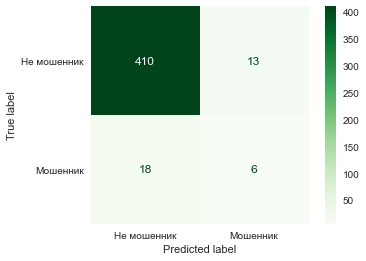

In [140]:
print('На тестовой выборке:')
print(classification_report(y_test, y_pred_test))
conf_matrix(y_test, y_pred_test)

На тестовой выборке:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       423
           1       0.21      0.21      0.21        24

    accuracy                           0.91       447
   macro avg       0.58      0.58      0.58       447
weighted avg       0.91      0.91      0.91       447



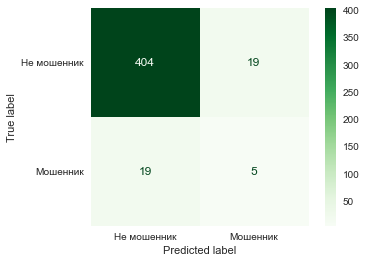

In [26]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1,
    max_depth=5, random_state=21, max_features = 'auto',
                                 criterion='friedman_mse', loss = 'deviance',  min_samples_split= 0.22727272727272736,
                                 min_samples_leaf= 1).fit(X_train, y_train)

y_test_pred = clf.predict(X_test)

print('На тестовой выборке:')
print(classification_report( y_test, y_test_pred))
conf_matrix(y_test, y_test_pred)

In [27]:
print(f1_score(y_test, y_test_pred))

0.20833333333333334
